In [47]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from torch_geometric.nn.pool import global_mean_pool
import torch.nn.functional as F


In [32]:
design_matrix = pd.read_csv("aki_data/design_matrix.tsv", sep="\t")

In [33]:
def load_graph(patient_id, type):
    if type == 1:
        with open(f'graph_data/type1/type1_patient_graph_{patient_id}.pkl', 'rb') as f:
            graph = pickle.load(f)
    return graph

def map_edges_to_indices(edge_list):
    # Create a unique mapping for each node
    unique_nodes = set([node for edge in edge_list for node in edge])
    node_to_idx = {node: idx for idx, node in enumerate(unique_nodes)}

    # Map edges to indices
    edge_index = [[node_to_idx[edge[0]], node_to_idx[edge[1]]] for edge in edge_list]
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()


In [37]:
train_graph_data= []
test_graph_data = []
patient_ids = design_matrix['sample'].values

for patient_id in patient_ids:
    graph = load_graph(patient_id, type=1)  # Load the graph as before

    # Convert NetworkX graph to PyTorch Geometric Data
    edge_index = map_edges_to_indices(graph.edges)

    x = torch.tensor([graph.nodes[node].get('abundance', 0) for node in graph.nodes], dtype=torch.float).unsqueeze(1)
    # reshaüe x to [num_nodes, num_node_features]
    y = torch.tensor([design_matrix[design_matrix['sample'] == patient_id]['group'].iloc[0]], dtype=torch.long)
    graph_data = Data(x=x, edge_index=edge_index, y=y)

    if 'M2012' in patient_id:
        train_graph_data.append(graph_data)
    else:
        test_graph_data.append(graph_data)

In [97]:
train_graph_data[0]

Data(x=[2585, 1], edge_index=[2, 2603], y=[1])

In [98]:
print(f"Number of training graphs: {len(train_graph_data)}")
print(f"Number of test graphs: {len(test_graph_data)}")
print(f"Number of features: {train_graph_data[0].num_features}")
print(f"Number of classes: {np.unique([graph.y.detach().numpy()[0] for graph in train_graph_data])}")
print(f"Is directed: {train_graph_data[0].is_directed()}")
print(train_graph_data[0])

Number of training graphs: 141
Number of test graphs: 56
Number of features: 1
Number of classes: [1 2]
Is directed: True
Data(x=[2585, 1], edge_index=[2, 2603], y=[1])


In [128]:
class GCNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5, batch_norm=True):
        super(GCNBlock, self).__init__()

        self.conv = GCNConv(in_channels, out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.batch_norm = batch_norm

        if self.batch_norm:
            self.bn = torch.nn.BatchNorm1d(out_channels)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        if self.batch_norm:
            x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

class SimpleGCN(torch.nn.Module):
    def __init__(self, num_features, layer_configs, num_classes):
        super(SimpleGCN, self).__init__()

        initial_layer = layer_configs[0]
        self.initial = GCNBlock(num_features, initial_layer['out_channels'], initial_layer['dropout_rate'], initial_layer['batch_norm'])

        self.hidden_layers = torch.nn.ModuleList()
        for layer_config in layer_configs[1:]:
            self.hidden_layers.append(GCNBlock(layer_config['in_channels'], layer_config['out_channels'], layer_config['dropout_rate'], layer_config['batch_norm']))

    def forward(self, x, edge_index, batch):
        x = self.initial(x, edge_index)
        for layer in self.hidden_layers:
            x = layer(x, edge_index)
        x = global_mean_pool(x, batch)
        return x

layer_configs = [
    {"in_channels": 32, "out_channels": 32, "dropout_rate": 0.3, "batch_norm": True},
]

In [99]:
def train(train_data, model, optimizer, loss_fn, device):

    model.train()
    running_loss = 0
    correct = 0
    total = 0


    for batch in train_data:
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = out.argmax(dim=1)
        total += batch.y.size(0)
        correct += pred.eq(batch.y).sum().item()
    
    return running_loss / len(train_data), correct / total


def validate(test_data, model, loss_fn, device):

    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_data:
            batch = batch.to(device)

            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y)

            running_loss += loss.item()
            pred = out.argmax(dim=1)

            total += batch.y.size(0)
            correct += pred.eq(batch.y).sum().item()

    return running_loss / len(test_data), correct / total
        

In [129]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

lr = 0.005
weight_decay = 0.0001
batch_size = 8

model = SimpleGCN(train_graph_data[0].num_features, layer_configs, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_graph_data, batch_size=batch_size)
test_loader = DataLoader(test_graph_data, batch_size=batch_size)

num_epochs = 100

results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in range(num_epochs):
    train_loss, train_acc = train(train_loader, model, optimizer, loss_fn, device)
    test_loss, test_acc = validate(test_loader, model, loss_fn, device)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")



Using device: cpu
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) A

In [117]:
def plot_results(results):
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(results["train_loss"], label="Train Loss")
    ax[0].plot(results["test_loss"], label="Test Loss")
    ax[0].set_title("Loss")
    ax[0].legend()

    ax[1].plot(results["train_acc"], label="Train Accuracy")
    ax[1].plot(results["test_acc"], label="Test Accuracy")
    ax[1].set_title("Accuracy")
    ax[1].legend()

    plt.show()

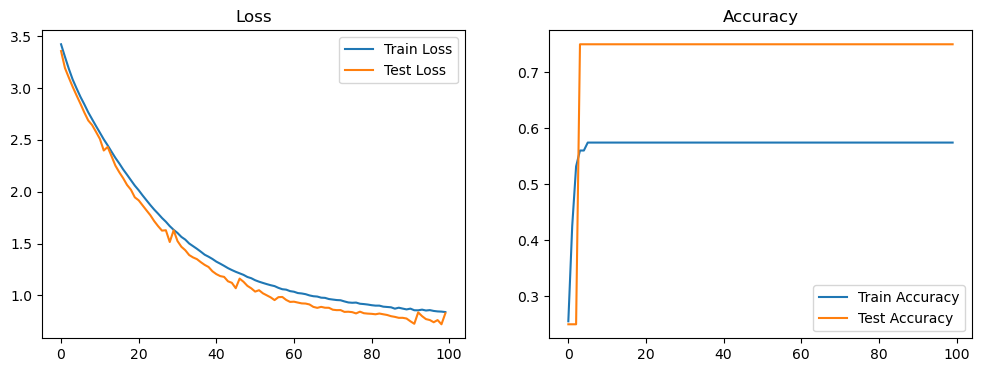

In [130]:
plot_results(results)